<a href="https://colab.research.google.com/github/cryptodb/data/blob/main/btc_eth_ltc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%%

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# assert tf.executing_eagerly()

from sklearn.preprocessing import MinMaxScaler


import pandas as pd
import requests
import io

# # Username of your GitHub account

# username = 'REPLACE-THIS-WITH-YOUR-GITHUB-ACCOUNT-USERNAME'

# # Personal Access Token (PAO) from your GitHub account

# token = 'REPLACE-THIS-WITH-YOUR-GITHUB-ACCOUNT-PAO'

# # Creates a re-usable session object with your creds in-built

# github_session = requests.Session()
# github_session.auth = (username, token)
    
# # Downloading the csv file from your GitHub

# url = "https://github.com/cryptodb/CryptoML/blob/master/btc_eth_ltc_minutes_coingeko.csv" # Make sure the url is the raw version of the file on GitHub
# download = github_session.get(url).content

# # Reading the downloaded content and making it a pandas dataframe

# df = pd.read_csv(io.StringIO(download.decode('utf-8')))
# btc_eth_ltc_coingeko_minute.csv
csv_path = "https://github.com/cryptodb/data/raw/main/btc_eth_ltc_minutes_coingeko.csv"
# csv_path = "btc_eth_ltc_minutes_coingeko.csv"
df = pd.read_csv(csv_path, parse_dates=['time'])
df = df.sort_values('time')

#%%




In [16]:

scaler = MinMaxScaler()
predict_value = 'ltc_close'
time_frame = 'minutes'
close_price = df.ltc_close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

#%%

scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

#%%

SEQ_LEN = 3*60

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

#%%



In [ ]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1
EMBEDDING_DIM = 64
model = keras.Sequential()

model.add(Bidirectional(
  CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
  input_shape=(WINDOW_SIZE, X_train.shape[-1])
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)
))

model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(
  CuDNNLSTM(WINDOW_SIZE, return_sequences=False)
))

model.add(Dense(units=1))

model.add(Activation('linear'))
print(model.summary())

#%%

BATCH_SIZE = 200
print('batch='+str(BATCH_SIZE)+ ' SEQ=' + str(SEQ_LEN) + ' time frame '+ time_frame +'\n file=' + csv_path, ' predict_value= ' + predict_value)
model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.15
)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 179, 358)          260624    
_________________________________________________________________
dropout_6 (Dropout)          (None, 179, 358)          0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 179, 716)          2056352   
_________________________________________________________________
dropout_7 (Dropout)          (None, 179, 716)          0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 358)               1284504   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 359       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                

In [12]:
#%%

y_hat = model.predict(X_test)

#%%

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

#%%

model.evaluate(X_test, y_test)
#%%

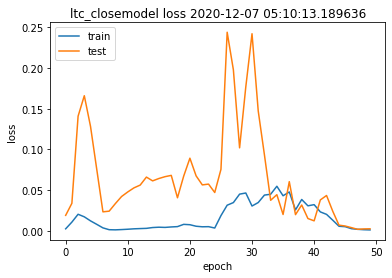

In [14]:

import datetime
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(predict_value + "model loss " + str( datetime.datetime.now()))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#%%


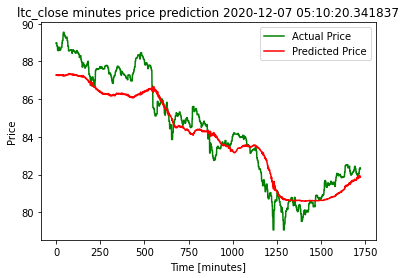

In [15]:

y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')

plt.title(predict_value +" " + time_frame +" price prediction " + str(datetime.datetime.now()))
plt.xlabel('Time ['+time_frame +']')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show();

In [ ]:
plt.plot(y_test, label="Actual Price", color='green')
plt.plot(y_hat, label="Predicted Price", color='red')

plt.title(predict_value +" " + time_frame +" price prediction scaled " + str(datetime.datetime.now()))
plt.xlabel('Time ['+time_frame +']')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show();